In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

In [ ]:
 import shutil

try: 
  shutil.rmtree("./EVA5")

except:
  pass

In [ ]:
!git clone https://github.com/abishek-raju/EVA5.git

Cloning into 'EVA5'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 177 (delta 24), reused 85 (delta 13), pack-reused 81
Receiving objects: 100% (177/177), 160.49 MiB | 34.85 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Checking out files: 100% (73/73), done.


In [ ]:
import os
os.chdir('/content/EVA5/S11')

In [ ]:
os.listdir()

['main_onecycle_gradcam.ipynb',
 'run.py',
 'plots.py',
 'lr_finder_fast_ai.py',
 'main.py',
 'resnet_build.py',
 'loss.png',
 'model.py',
 'gradcam.py',
 'test',
 'trained.pt',
 'Gradcam_out',
 'data.py',
 'utils.py',
 'device.py',
 'Incorrect_GC',
 'gbn.py',
 'cyclic_learning_rate.ipynb',
 'trained50ep.pt',
 'trained_quiz.pt']

In [ ]:
import pkg_resources
import sys
if ((pkg_resources.get_distribution('albumentations').version == "0.5.2")):
  pass
else:
  !pip install -U git+https://github.com/albu/albumentations --no-cache-dir
  exit()

In [ ]:
if 'torch_lr_finder' not in sys.modules:
  !pip install torch_lr_finder
else:
  pass

In [ ]:
# !pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [ ]:
############ DATA & TRANSFORMS

from data import get_data
from device import get_device

device = get_device(force_cpu=False)


horizontal_flip_prob = 0.2
vertical_flip_prob = 0.0
gaussian_blur_prob = 0.0
rotate_degree = 20
cutout = 0.3
#
transform_args = {}


transform_args['horizontal_flip_prob'] =  0.2
transform_args['vertical_flip_prob'] = 0.0
transform_args['gaussian_blur_prob'] = 0.0
transform_args['rotate_degree'] = 20
transform_args['cutout'] = 0.3
transform_args['cutout_height'] = 16
transform_args['cutout_width'] = 16


train_loader, test_loader = get_data(device,transform_args,batch_size=512 )

/usr/local/lib/python3.7/dist-packages/albumentations/pytorch/transforms.py:58: FutureWarning: ToTensor is deprecated and will be replaced by ToTensorV2 in albumentations 0.7.0
  "ToTensor is deprecated and will be replaced by ToTensorV2 in albumentations 0.7.0", FutureWarning



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_loader.dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
train_loader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: <data.Transforms object at 0x7f9245b1b410>

In [ ]:
# !pip install torch_lr_finder

In [ ]:
from model import main11

In [ ]:
from torchsummary import summary
model = main11().to("cuda")

In [ ]:
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
       BasicBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         295,168
        MaxPool2d-14            [-1, 25

/content/EVA5/S11/model.py:122: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outX)


In [ ]:
!pip install pytorch_lr_finder

In [ ]:
from torch_lr_finder import LRFinder

In [ ]:
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=100, step_mode="exp")

/content/EVA5/S11/model.py:122: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outX)


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 6.28E-04


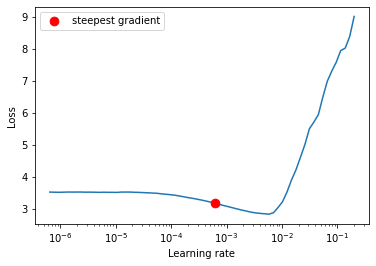

In [ ]:
lr_finder.plot()
lr_finder.reset()

In [ ]:
incorrectSamples = []
correctSamples = []
correctLabels = []
learningRates = []
model = main11().to(device)
EPOCHS = 24

criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.018, momentum=0.95, weight_decay = 1e-2, nesterov = True) 
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.02, total_steps=2400, epochs = 24, steps_per_epoch=len(train_loader),
                                                pct_start=5/EPOCHS, anneal_strategy='linear', cycle_momentum=True, 
                                                base_momentum=0.85, max_momentum=0.95, div_factor=24, final_div_factor=1)

In [ ]:
model.train()

customNet(
  (conv): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
    )
  )
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Sequential(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
    )
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
    )
  )
  (res1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(128, 128, kernel_si

In [ ]:
train_acc = []
train_losses = []
def train(model,trainloader, 
            epoch,num_epochs,device,optimizer,criterion,scheduler,
            L1lambda=None):
  """
  Args:-
  trainLoader: Dataloader for Train Dataset
  epoch: Number of Epochs
  L1lambda: L1lambda Value, by default set to None
  """


  model.train()    # prepare model for training
  pbar = tqdm(enumerate(trainloader),total=len(trainloader),leave = True)
  correct = 0
  processed = 0
  loss = 0
  for batch_idx, (data, target) in pbar: # passing on data & target values to device
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()    # clear the gradients of all optimized variables

    # Predict
    y_pred = model(data)   # forward pass


    # Calculate loss
    c_loss = criterion(y_pred, target)

    #Implementing L1 Regularization
    if L1lambda:
      with torch.enable_grad():
        l1_loss = 0.
        for param in model.parameters():
          l1_loss += torch.sum(param.abs())
        loss = c_loss +  (L1lambda * l1_loss)
    else:
      loss = c_loss
    loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
    optimizer.step()   # perform a single optimization step (parameter update)
    scheduler.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Epoch [{epoch}/{num_epochs}]')
    pbar.set_postfix(loss_ = loss.item(),acc_ = 100*correct/processed)
  train_acc.append(100*correct/processed)
  train_losses.append(loss)

In [ ]:
import numpy as np

In [ ]:
correct_samples = []
incorrect_samples = []
correctLabels = []
test_acc = []
test_losses = []
test_loss_min = np.inf
def test(model,
        testloader, 
        filename, 
        correct_samples, 
        correctLabels, 
        incorrect_samples):
    
  model.eval()  # prep model for evaluation
  test_loss = 0
  correct = 0
  processed = 0
  pbar = tqdm(enumerate(testloader),total=len(testloader),leave = True)
  with torch.no_grad(): # setting gradients back to zero
      for batch_idx,(data, target) in pbar:

        img_batch = data # this is done to store data
        data, target = data.to(device), target.to(device)

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # sum up batch loss
        # test_loss += F.nll_loss(output, target, reduction='sum').item()
        test_loss = criterion(output, target).item()


        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        # storing the entire result data as binary
        result = pred.eq(target.view_as(pred))
        # scheduler.step()

        # # This is to extract incorrect samples/misclassified images
        # if len(incorrect_samples) < 25:
        #   for i in range(0, testloader.batch_size):
        #     if not list(result)[i]:
        #       incorrect_samples.append({'prediction': list(pred)[i], 'label': list(target.view_as(pred))[i],'image': img_batch[i]})


        # # this is to extract correct samples/classified images
        # if len(correct_samples) < 25:
        #   for i in range(0, testloader.batch_size):
        #     if list(result)[i]:
        #       correct_samples.append({'prediction': list(pred)[i], 'label': list(target.view_as(pred))[i],'image': img_batch[i]})
        #       correctLabels.append(list(target.view_as(pred))[i]) # this is for gradcam



  # save model if validation loss has decreased
  # if test_loss <= test_loss_min:
  #     print('Validation loss has  decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(test_loss_min,test_loss ))
  #     torch.save(model.state_dict(), filename)
  #     test_loss_min = test_loss


  # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
  #     test_loss, correct, len(testloader.dataset),
  #     100. * correct / len(testloader.dataset)))
        # pbar.set_description(desc= f'Epoch [{epoch}/{num_epochs}]')
        processed += len(data)
        pbar.set_postfix(loss_ = test_loss,acc_ = 100. * correct / processed)

  test_acc.append(100. * correct / len(testloader.dataset))
  test_losses.append(test_loss)

In [ ]:
from tqdm.notebook import tqdm


In [ ]:
num_of_epochs = 24
for epoch in range(1, num_of_epochs+1):
  print('EPOCH: ',epoch)
  train(model,train_loader, epoch,num_of_epochs,"cuda",optimizer,criterion,scheduler, L1lambda=1e-5)
  scheduler.step()
  test(model,test_loader, "model_tut.pt", correct_samples, correctLabels, incorrect_samples)
  for param_group in optimizer.param_groups:
    print('Learning Rate = {a} for EPOCH {e}'.format(a = round(param_group['lr'],5), e=epoch+1))
    learningRates.append(param_group['lr'])

EPOCH:  1


/content/EVA5/S11/model.py:122: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outX)



Learning Rate = 0.00464 for EPOCH 2
EPOCH:  2



Learning Rate = 0.00844 for EPOCH 3
EPOCH:  3



Learning Rate = 0.01224 for EPOCH 4
EPOCH:  4



Learning Rate = 0.01604 for EPOCH 5
EPOCH:  5



Learning Rate = 0.01985 for EPOCH 6
EPOCH:  6



Learning Rate = 0.01904 for EPOCH 7
EPOCH:  7



Learning Rate = 0.01804 for EPOCH 8
EPOCH:  8



Learning Rate = 0.01704 for EPOCH 9
EPOCH:  9



Learning Rate = 0.01605 for EPOCH 10
EPOCH:  10



Learning Rate = 0.01505 for EPOCH 11
EPOCH:  11



Learning Rate = 0.01405 for EPOCH 12
EPOCH:  12



Learning Rate = 0.01305 for EPOCH 13
EPOCH:  13



Learning Rate = 0.01205 for EPOCH 14
EPOCH:  14



Learning Rate = 0.01105 for EPOCH 15
EPOCH:  15



Learning Rate = 0.01005 for EPOCH 16
EPOCH:  16



Learning Rate = 0.00905 for EPOCH 17
EPOCH:  17



Learning Rate = 0.00806 for EPOCH 18
EPOCH:  18



Learning Rate = 0.00706 for EPOCH 19
EPOCH:  19



Learning Rate = 0.00606 for EPOCH 20
EPOCH:  20



Learning Rate = 0.00506 for EPOCH 21
EPOCH:  21



Learning Rate = 0.00406 for EPOCH 22
EPOCH:  22



Learning Rate = 0.00306 for EPOCH 23
EPOCH:  23



Learning Rate = 0.00206 for EPOCH 24
EPOCH:  24



Learning Rate = 0.00107 for EPOCH 25


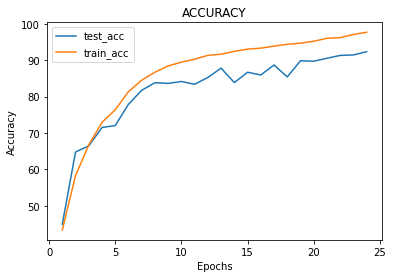

In [ ]:
import matplotlib.pyplot as plt
  
# line 1 points
x1 = range(1,len(test_acc)+1)
y1 = test_acc
# plotting the line 1 points 
plt.plot(x1, y1, label = "test_acc")
  
# line 2 points
x2 = range(1,len(train_acc)+1)
y2 = train_acc
# # plotting the line 2 points 
plt.plot(x2, y2, label = "train_acc")
  
# naming the x axis
plt.xlabel('Epochs')
# naming the y axis
plt.ylabel('Accuracy')
# giving a title to my graph
plt.title('ACCURACY')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

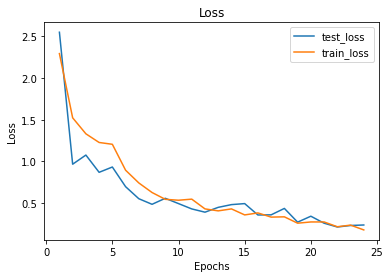

In [ ]:
# line 1 points
x1 = range(1,len(test_losses)+1)
y1 = test_losses
# plotting the line 1 points 
plt.plot(x1, y1, label = "test_loss")
  
# line 2 points
x2 = range(1,len(train_losses)+1)
y2 = train_losses
# # plotting the line 2 points 
plt.plot(x2, y2, label = "train_loss")
  
# naming the x axis
plt.xlabel('Epochs')
# naming the y axis
plt.ylabel('Loss')
# giving a title to my graph
plt.title('Loss')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()